In [1]:
import json
import os
from typing import Optional

import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm, SymLogNorm, AsinhNorm
from IPython.display import display, HTML
import shapely
from shapely.ops import linemerge, split
from tqdm import tqdm

In [2]:
def plot_in_country_trade_flows(
    edges: gpd.GeoDataFrame,
    vmin: float,
    vmax: float,
    filename: Optional[str] = None,
) -> None:
    f, ax = plt.subplots(figsize=(12, 12))
    
    to_plot = edges[
        (edges.volume_tons != 0) 
        & edges["mode"].isin(
            {
                'road_rail',
                'maritime_road',
                'maritime_rail',
                'road',
                'rail',
                #'maritime',
                #'imaginary'
            }
        )
    ]
    not_imaginary_mask = to_plot["mode"] != "imaginary"
    norm = LogNorm(10**np.log10(vmin), 10**np.log10(vmax))
    to_plot[not_imaginary_mask].sort_values("volume_tons").plot(
        "volume_tons", ax=ax, legend=True, norm=norm, alpha=0.7, legend_kwds={"shrink": 0.5, "label": "Flow volume [t/d]"}, cmap="magma_r"
    )
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.set_yticks(range(5, 22))
    ax.set_xticks(range(98, 106))
    world.plot(ax=ax, lw=0.5, alpha=0.2)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.grid(alpha=0.3)
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    if filename:
        f.savefig(filename)

In [3]:
def year_to_day(df: pd.DataFrame, cols=("value_kusd", "volume_tons")) -> pd.DataFrame:
    for col in cols:
        df[col] /= 365.24
    return df

In [4]:
def least_n_hash(x: str, n: int = 12) -> int:
    """Return the least significant n digits of hash(x)."""
    return int(str(hash(x))[-n:])

In [5]:
def preprocess_edges(edges: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Move from yearly to daily figures
    Drop 0 volume edges
    Drop maritime and imaginary links
    Combine bidirectional edge pairs into a single edge with the sum of the volumes and values
    """
        
    edges = year_to_day(edges)
    edges = edges[(edges.volume_tons != 0) & edges["mode"].isin({'road_rail', 'maritime_road', 'maritime_rail', 'road', 'rail'})]
    edges["undirected_id"] = edges.loc[:, ["from_id", "to_id"]].apply(
        lambda row: least_n_hash(row.from_id) + least_n_hash(row.to_id),
        axis=1
    )
    undirected_flows = edges.loc[:, ["undirected_id", "value_kusd", "volume_tons"]].groupby("undirected_id").sum()
    undirected_edge_flows = edges.drop_duplicates("undirected_id") \
        .set_index("undirected_id") \
        .drop(columns=["value_kusd", "volume_tons"]) \
        .join(undirected_flows)
    
    return undirected_edge_flows

In [6]:
plt.style.use("bmh")

root_dir = ".."

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.geometry = world.geometry.boundary
countries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))

nominal_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/")
degraded_dir = os.path.join(root_dir, "results/flow_allocation/project-thailand/hazard-thai-floods-2011-JBA/")
nominal_edges = gpd.read_parquet(os.path.join(nominal_dir, "edges.gpq"))
degraded_edges = gpd.read_parquet(os.path.join(degraded_dir, "edges.gpq"))
data = {
    "nominal": {
        "edges": preprocess_edges(nominal_edges),
        "routes": year_to_day(pd.read_parquet(os.path.join(nominal_dir, "routes_with_costs.pq"))),
    },
    "degraded": {
        "edges": preprocess_edges(degraded_edges),
        "routes": year_to_day(pd.read_parquet(os.path.join(degraded_dir, "routes_with_costs.pq"))),
    }
}

/tmp/ipykernel_4010254/2919005362.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/home/fred/micromamba/envs/wb_flood/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/fred/micromamba/envs/wb_flood/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

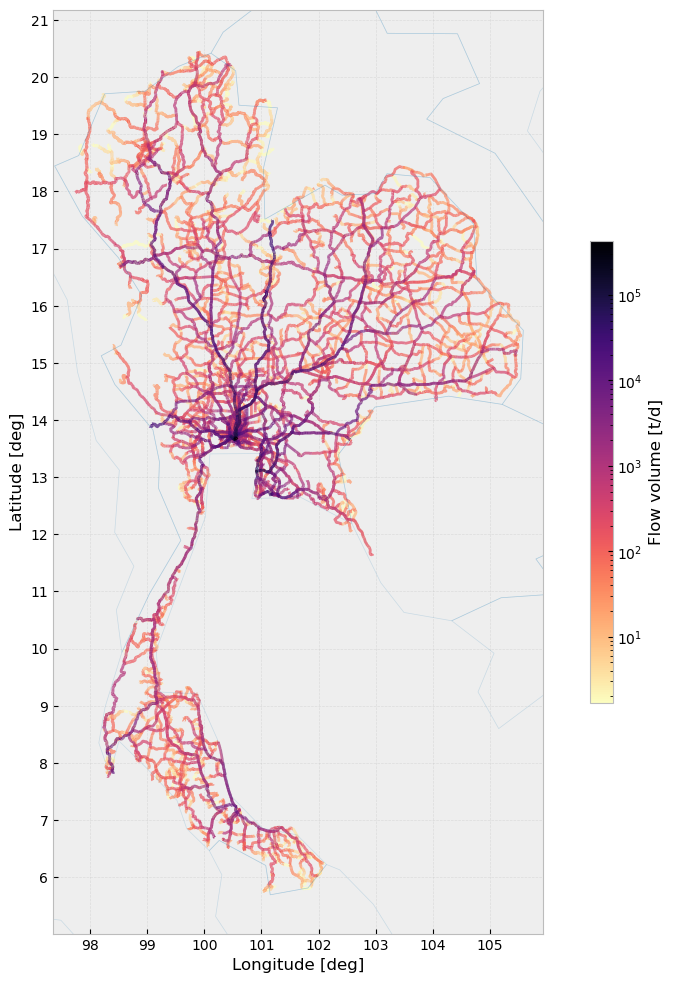

In [7]:
edges = data["nominal"]["edges"]
vmin = edges.volume_tons.quantile(0.1)
vmax = edges.volume_tons.max()
plot_in_country_trade_flows(edges, vmin, vmax, "undirected.png")

In [8]:
def find_flow_delta(nominal: gpd.GeoDataFrame, degraded: gpd.GeoDataFrame) -> gpd.GeoDataFrame:

    # left join uses full set of edges from nominal network
    delta = nominal.rename(
        columns={
            "value_kusd": "nominal_value_kusd",
            "volume_tons": "nominal_volume_tons"
        }
    ).join(degraded.loc[:, ["value_kusd", "volume_tons"]], how="left").rename(
        columns={
            "value_kusd": "degraded_value_kusd",
            "volume_tons": "degraded_volume_tons"
        }
    ).fillna(0)
    
    delta["value_kusd"] = delta["degraded_value_kusd"] - delta["nominal_value_kusd"]
    delta["value_kusd_perc"] = 100 * delta["value_kusd"] / delta["nominal_value_kusd"]
    delta["value_kusd_factor"] = delta["degraded_value_kusd"] / delta["nominal_value_kusd"]
    
    delta["volume_tons"] = delta["degraded_volume_tons"] - delta["nominal_volume_tons"]
    delta["volume_tons_perc"] = 100 * delta["volume_tons"] / delta["nominal_volume_tons"]
    delta["volume_tons_factor"] = delta["degraded_volume_tons"] / delta["nominal_volume_tons"]

    return delta

nominal = data["nominal"]["edges"].copy()
degraded = data["degraded"]["edges"].copy()
delta = find_flow_delta(nominal, degraded)

In [9]:
# we'd like some extra attributes
# specifically, the road names and reference numbers

# we can get to the road names and numbers if we have an OSM way id
# first, join with the original road network to recover these way ids
road_edges = gpd.read_parquet(
    "/home/fred/projects/world_bank/2024_thailand/results/input/networks/road/project-thailand/edges.gpq"
)
road_edges.osm_way_id = road_edges.osm_way_id.astype(int)
road_edges["from_id"] = "road_" + road_edges.from_id
road_edges["to_id"] = "road_" + road_edges.to_id
road_edges["undirected_id"] = road_edges.loc[:, ["from_id", "to_id"]].apply(
    lambda row: least_n_hash(row.from_id) + least_n_hash(row.to_id),
    axis=1
)
road_edges = road_edges.set_index("undirected_id")

# ok, now we need to use the OSM way ids to join against the original extract with all the tags

# ogr2ogr --config OSM_CONFIG_FILE=osmconf.ini thai_roads_OSM.gpkg thailand-latest_filter-road-secondary.osm.pbf lines
# with osmconf.ini:
# [lines]
# osm_id=yes
# attributes=name,name:en,ref,classification,highway,surface

road_edges_osm_extract = gpd.read_file(
    "/home/fred/projects/open_gira/open-gira/results/input/OSM/thai_roads_OSM.gpkg"
)
road_edges_osm_extract["osm_id"] = road_edges_osm_extract["osm_id"].astype(int)
road_edges_osm_extract = road_edges_osm_extract.set_index("osm_id")

road_edges_osm = road_edges \
    .reset_index() \
    .set_index("osm_way_id") \
    .join(road_edges_osm_extract.drop(columns=["other_tags", "geometry"]), how="left")

# drop non-Thai edges
road_edges_osm = road_edges_osm[road_edges_osm.from_iso_a3 == "THA"]

df = road_edges_osm.loc[:, ['undirected_id', 'segment_id', 'name_en', 'ref', 'classification',
    'highway', 'tag_highway', 'tag_surface', 'surface', 'paved', 'material', 'lanes',
    'from_id', 'to_id', 'from_iso_a3', 'to_iso_a3', 'asset_type', 
]].reset_index().set_index("undirected_id") \
    .join(
        delta.loc[:, ['geometry', 'nominal_value_kusd', 'nominal_volume_tons',
           'degraded_value_kusd', 'degraded_volume_tons', 'value_kusd',
           'value_kusd_perc', 'value_kusd_factor', 'volume_tons',
           'volume_tons_perc', 'volume_tons_factor']
        ]
    )

df = df[~df.volume_tons.isna()]
df["abs_volume_tons"] = np.abs(df.volume_tons)
df = gpd.GeoDataFrame(df.sort_values("abs_volume_tons", ascending=False))

df.to_parquet("thailand_floods_trade_flow_delta.gpq")
df.to_file("thailand_floods_trade_flow_delta.gpkg")

# df now contains all the flow changes, plus the name, reference and other tags for context

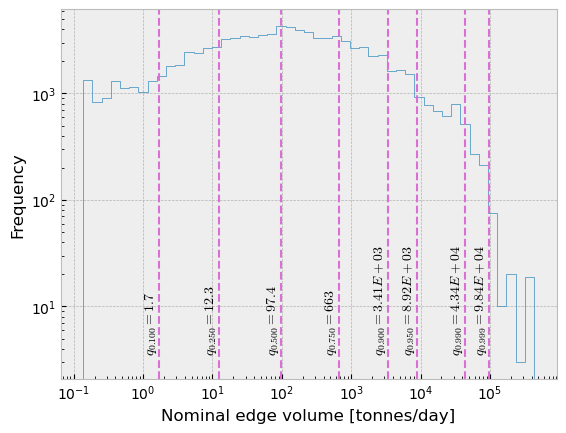

In [10]:
# plot the flow volume distribution over edges

f, ax = plt.subplots()
var = nominal.volume_tons
counts, bin_edges, patches = ax.hist(
    var,
    bins=np.logspace(np.log10(np.min(var)), np.log10(np.max(var)), 50),
    histtype='step',
)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel(r"Nominal edge volume [tonnes/day]")
for q in [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]:
    value = var.quantile(q)
    ax.axvline(value, ls="--", lw=1.5, color="orchid")
    ax.text(
        value,
        10**(0.15 * np.log10(max(counts))),
        f"$q_{{{q:.3f}}}={{{value:.3G}}}$",
        rotation=90,
        horizontalalignment='right',
        verticalalignment='bottom'
    )

Text(0.5, 0, 'Degraded $-$ nominal volume [tonnes/day]')

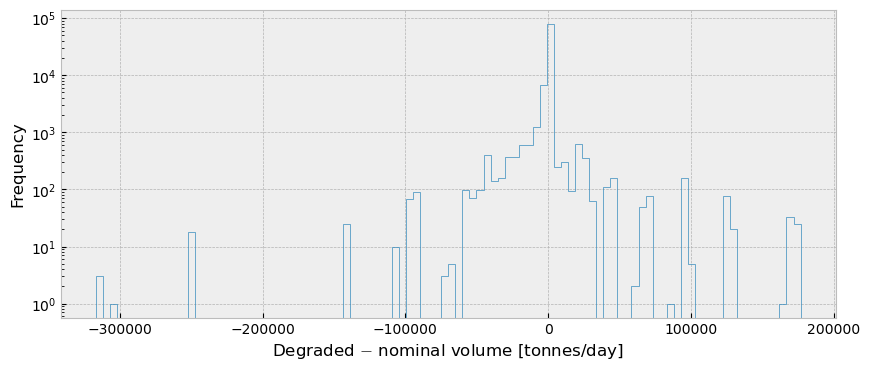

In [11]:
# plot the distribution of changes in flow volume

f, ax = plt.subplots(figsize=(10, 4))
var = delta.volume_tons
ax.hist(var, bins=100, histtype="step")
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel(r"Degraded $-$ nominal volume [tonnes/day]")

In [12]:
# derive some quantities from the change in volume_tons to help plotting

to_plot = delta.copy()
to_plot = to_plot[~to_plot.volume_tons.isna()]
# put values close to zero near the end, so they will render underneath values of interest
to_plot["volume_tons_squared"] = to_plot["volume_tons"] ** 2
to_plot = to_plot[to_plot["volume_tons_squared"] > to_plot["volume_tons"].quantile(0.1) ** 2]
to_plot = to_plot.sort_values("volume_tons_squared", ascending=False)
to_plot["alpha"] = np.clip(np.sqrt(to_plot.volume_tons_squared) / np.sqrt(to_plot.volume_tons_squared.quantile(0.5)), 0.33, 1)
to_plot.loc[:, ["volume_tons", "volume_tons_squared", "alpha"]]

,volume_tons,volume_tons_squared,alpha
undirected_id,,,
1862745904272,-316646.690208,1.002651e+11,1.00
1398702568698,-316613.446940,1.002441e+11,1.00
560206004281,-316610.580814,1.002423e+11,1.00
1587126831380,-304135.399396,9.249834e+10,1.00
487735562078,-251233.518297,6.311828e+10,1.00
...,...,...,...
1153499040917,-1438.893635,2.070415e+06,0.33
1216861095642,-1438.893635,2.070415e+06,0.33
1198593728781,-1438.893635,2.070415e+06,0.33


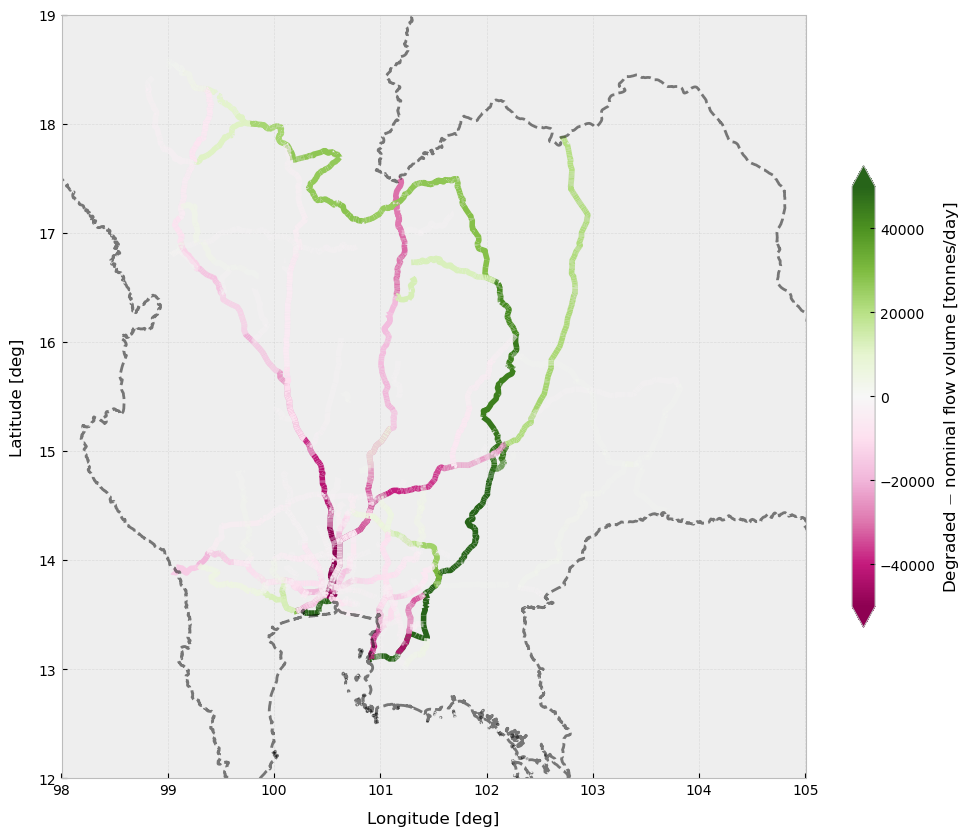

In [13]:
f, ax = plt.subplots(figsize=(12, 12))
half_width = 5E4
cmap = plt.get_cmap("PiYG")
to_plot.plot(
    column="volume_tons",
    cmap=cmap,
    ax=ax,
    legend=True,
    vmin=-half_width,
    vmax=half_width,
    lw=4,
    alpha=to_plot["alpha"],
    legend_kwds={
        "shrink": 0.5,
        "label": r"Degraded $-$ nominal flow volume [tonnes/day]",
        "extend": "both"
    }
)

ax.set_yticks(range(5, 22))
ax.set_xticks(range(98, 106))
ax.set_xlim(98, 105)
ax.set_ylim(12, 19)
thailand = countries[countries.GID_0 == "THA"].copy()
thailand.geometry = thailand.geometry.boundary
thailand.plot(ax=ax, ls="--", color="k", alpha=0.5)
ax.grid(alpha=0.3)
ax.set_xlabel("Longitude [deg]", labelpad=10)
ax.set_ylabel("Latitude [deg]", labelpad=10)
f.savefig("delta_linear.png")

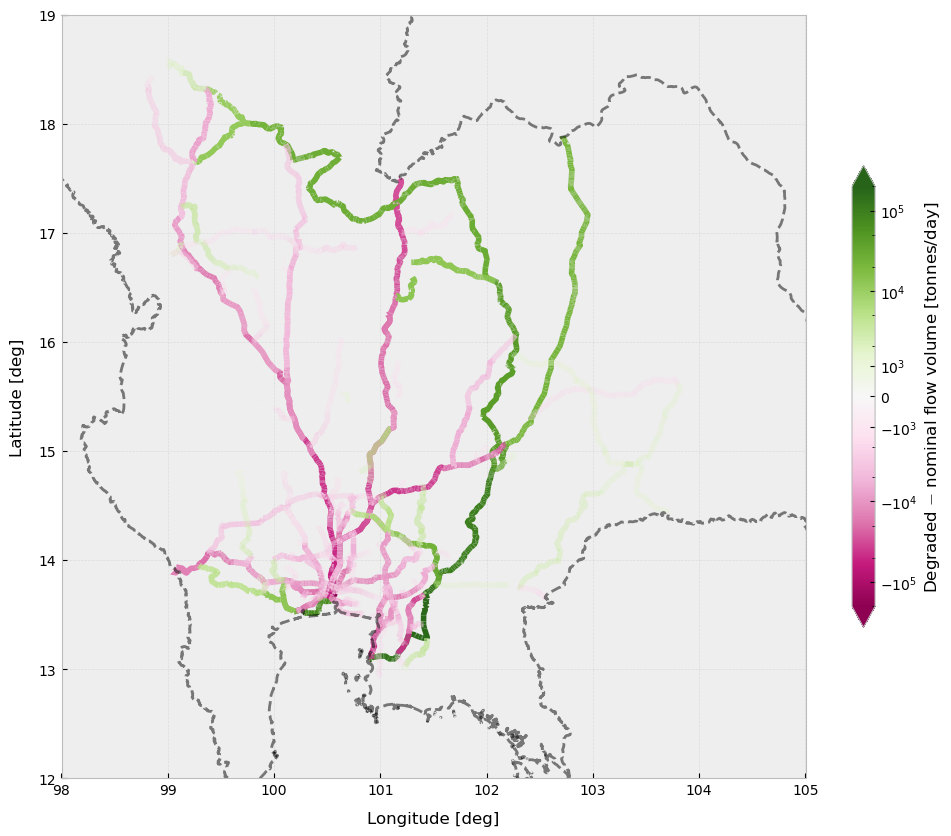

In [14]:
f, ax = plt.subplots(figsize=(12, 12))
half_width = 2E5
cmap = plt.get_cmap("PiYG")
to_plot.plot(
    column="volume_tons",
    cmap=cmap,
    ax=ax,
    legend=True,
    vmin=-half_width,
    vmax=half_width,
    norm=AsinhNorm(
        linear_width=1000,
        vmin=-half_width,
        vmax=half_width
    ),
    lw=4,
    alpha=to_plot["alpha"],
    legend_kwds={
        "shrink": 0.5,
        "label": r"Degraded $-$ nominal flow volume [tonnes/day]",
        "extend": "both"
    }
)

ax.set_yticks(range(5, 22))
ax.set_xticks(range(98, 106))
ax.set_xlim(98, 105)
ax.set_ylim(12, 19)
thailand = countries[countries.GID_0 == "THA"].copy()
thailand.geometry = thailand.geometry.boundary
thailand.plot(ax=ax, ls="--", color="k", alpha=0.5)
ax.grid(alpha=0.3)
ax.set_xlabel("Longitude [deg]", labelpad=10)
ax.set_ylabel("Latitude [deg]", labelpad=10)
f.savefig("delta_log.png")

In [15]:
top_n = 20
road_naming_attrs = df.set_index("osm_way_id").loc[:, ["name_en", "ref", "highway"]].drop_duplicates("name_en")
road_change_summary = df.set_index("osm_way_id").loc[:, ["volume_tons"]].groupby("osm_way_id").mean().join(road_naming_attrs, how="right")
loss = road_change_summary.sort_values("volume_tons").head(top_n)
gain = road_change_summary.sort_values("volume_tons", ascending=False).head(top_n)

In [16]:
loss

,volume_tons,name_en,ref,highway
osm_way_id,,,,
1055576187,-316613.446940,Nakhon Khuean Khan Road,None,secondary
83904212,-251225.522464,Phetchahueng Road,None,secondary
103929010,-249377.907219,Industrial Ring Road,None,secondary
83904161,-182573.170542,Phra Ratchawiriyaphon Road,None,secondary
622560005,-139775.247453,Nang Linchi Road,None,secondary
1009650596,-108118.367240,Suk Sawat Road,303,primary
1188901077,-98903.665299,Chaloem Mahanakhon Expressway,None,motorway
185077916,-96101.466156,Vibhavadi Rangsit Road,31,secondary
708687695,-58800.131036,Sirat Expressway,None,motorway


In [17]:
gain

,volume_tons,name_en,ref,highway
osm_way_id,,,,
695077994,176704.228290,None,3245,secondary
929494046,172501.456425,CCO.4012,ฉช.4012,secondary
719047592,126921.771892,Sukhumvit Road,3,trunk
152598604,96937.222413,304 Frontage Road,304,secondary
1096945980,96036.124859,Suep Siri Road,None,secondary
591176084,69673.787592,Liab Kling Phitthayalongkorn Road,สค.4008,secondary
590928640,69471.307671,Kijmanee Road,3423,secondary
1107775074,69436.420398,Ekkachai Road,None,secondary
637109774,69159.577737,Bang Khun Thian Chai Thale Road,None,secondary
